# Brain Tumor Identification
By Jonathan Nunez

abstract

# Business Understanding

# Data Understanding

In [ ]:
# For Google Colab only
# Cell output cleared as it only contains installation progress
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]
!pip install split-folders

In [2]:
# Importing tools and modules for data preperation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img

import random
import splitfolders

In [3]:
# Code to create kaggle path for data download
# Code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"",
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
# Downloading kaggle dataset
# Cell output cleared as only contains data download progress
!kaggle datasets download -d ishans24/brain-tumor-dataset

# Creating parent folder directory for data unzip
!mkdir /content/brain_tumor_dataset
!unzip brain-tumor-dataset.zip -d /content/brain_tumor_dataset

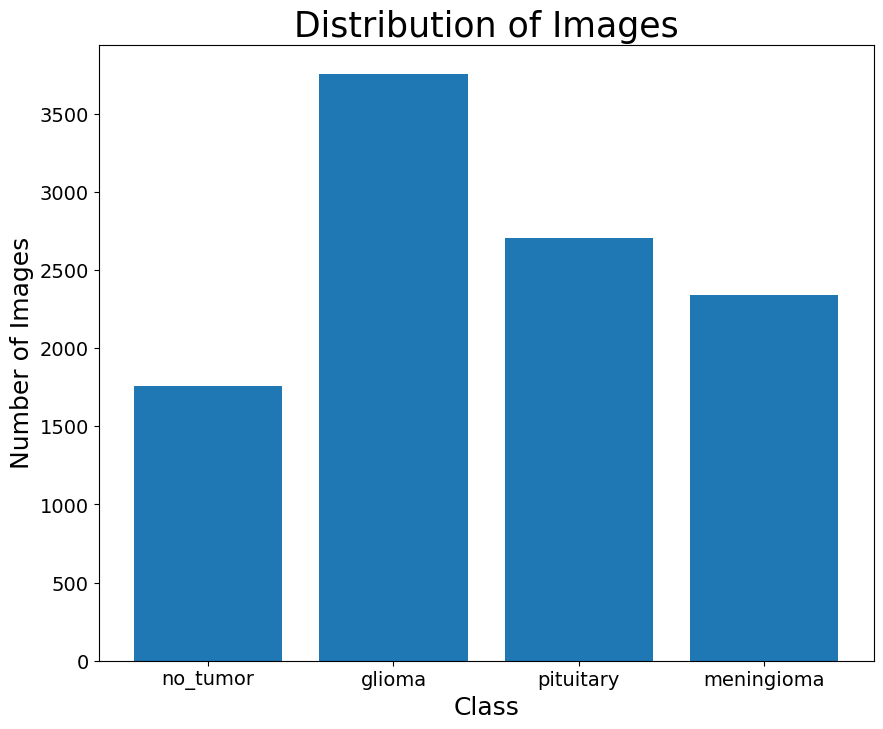

In [5]:
# Count the number of images in each class
directory = 'brain_tumor_dataset'
classes = os.listdir(directory)

image_counts = {cls: len(os.listdir(os.path.join(directory, cls))) for cls in classes}
df = pd.Series(image_counts)

# Plotting the distribution of images
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(df.index, df)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Distribution of Images', fontsize=25)
ax.set_xlabel('Class', fontsize=18)
ax.set_ylabel('Number of Images', fontsize=18);

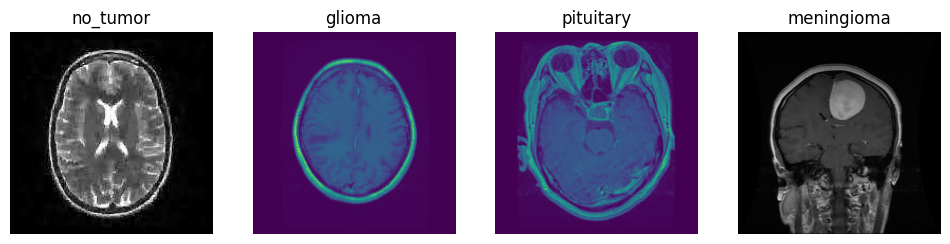

In [6]:
# Code to randomly display an image from each class
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, category in enumerate(['no_tumor', 'glioma', 'pituitary', 'meningioma']):
    path = os.path.join(directory, category)
    sample = random.choice(os.listdir(path))
    img = mpimg.imread(os.path.join(path, sample))

    axes[i].imshow(img)
    axes[i].set_title(f"{category}")
    axes[i].axis('off');

## Data preparation

In [7]:
# Splitting data into train, test, and validation data directories
splitfolders.ratio('brain_tumor_dataset', output='b_tumor_data_split', seed=42, ratio=(.7, 0.15, 0.15))

Copying files: 10560 files [00:01, 6202.30 files/s]


In [8]:
# Directory paths
train_dir = 'b_tumor_data_split/train'
test_dir = 'b_tumor_data_split/test'
val_dir = 'b_tumor_data_split/val'

In [9]:
# Variable to rescale images as its being imported
datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Importing brain tumor image data
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=7390,
                                              seed=42
                                              )

test_generator = datagen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=1588,
                                             seed=42
                                             )

val_generator = datagen.flow_from_directory(val_dir,
                                            target_size=(256, 256),
                                            batch_size=1582,
                                            seed=42
                                            )

Found 7390 images belonging to 4 classes.
Found 1588 images belonging to 4 classes.
Found 1582 images belonging to 4 classes.


In [11]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Modeling

In [12]:
# Importing modeling tools and modules
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import ResNet50, DenseNet121

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [13]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [14]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [15]:
data_dict = {
    'Train Data': (train_images, train_labels),
    'Val Data': (val_images, val_labels)
}

### Base CNN Model

In [16]:
base_cnn = Sequential()

In [17]:
base_cnn.add(layers.Input(shape=(256, 256, 3)))
base_cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D())

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(64, activation='relu'))
base_cnn.add(layers.Dropout(0.5))
base_cnn.add(layers.Dense(4, activation='softmax'))

In [18]:
base_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [19]:
base_cnn_results = base_cnn.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=100,
                                validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.4850 - loss: 2.0846 - val_accuracy: 0.7674 - val_loss: 0.5365
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7778 - loss: 0.5440 - val_accuracy: 0.8110 - val_loss: 0.4156
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8310 - loss: 0.4033 - val_accuracy: 0.8603 - val_loss: 0.3449
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8650 - loss: 0.3204 - val_accuracy: 0.8824 - val_loss: 0.3164
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8836 - loss: 0.2826 - val_accuracy: 0.8932 - val_loss: 0.2817
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9114 - loss: 0.2197 - val_accuracy: 0.9115 - val_loss: 0.2543
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9362 - loss: 0.1740 - val_accuracy: 0.9216 - val_loss: 0.2450
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9421 - loss: 0.1539 - val_accuracy: 0.9248 -

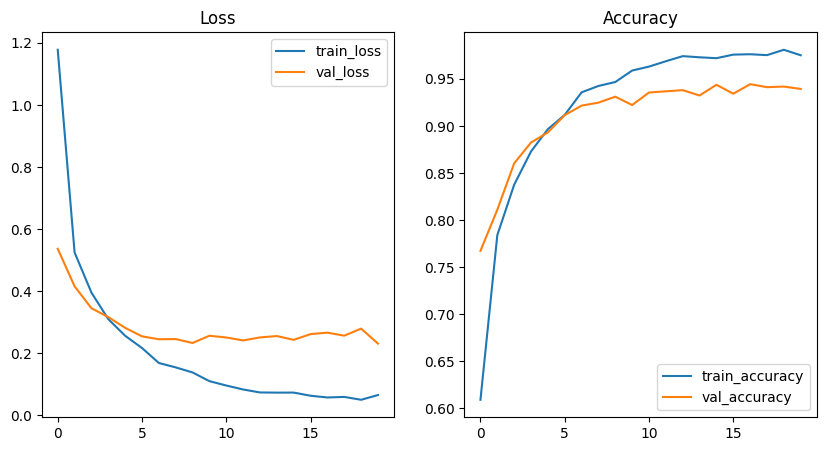

In [20]:
plot_results([base_cnn_results])

In [21]:
model_evaluation(base_cnn, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9988 - loss: 0.0060
Train Data, Loss: 0.0066, Accuracy: 0.9982
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9354 - loss: 0.2580
Val Data, Loss: 0.2309, Accuracy: 0.9393


### Base DenseNet Model

In [22]:
dn_base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
base_densenet = Sequential()
base_densenet.add(dn_base_model)
base_densenet.add(layers.GlobalAveragePooling2D())
base_densenet.add(layers.Dense(64, activation='relu'))
base_densenet.add(layers.Dropout(0.5))
base_densenet.add(layers.Dense(4, activation='softmax'))

In [24]:
base_densenet.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [25]:
base_densenet_results = base_densenet.fit(train_images, train_labels,
                                          epochs=20,
                                          batch_size=100,
                                          validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.7740 - loss: 0.6634 - val_accuracy: 0.5177 - val_loss: 3.9581
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.9465 - loss: 0.1698 - val_accuracy: 0.6884 - val_loss: 3.4572
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9578 - loss: 0.1383 - val_accuracy: 0.6618 - val_loss: 1.3467
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9761 - loss: 0.0853 - val_accuracy: 0.9450 - val_loss: 0.1648
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.9775 - loss: 0.0781 - val_accuracy: 0.8647 - val_loss: 0.8853
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.9823 - loss: 0.0649 - val_accuracy: 0.7035 - val_loss: 1.4358
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9745 - loss: 0.0818 - val_accuracy: 0.7124 - val_loss: 2.4224
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9793 - loss: 0.0633 - val_accura

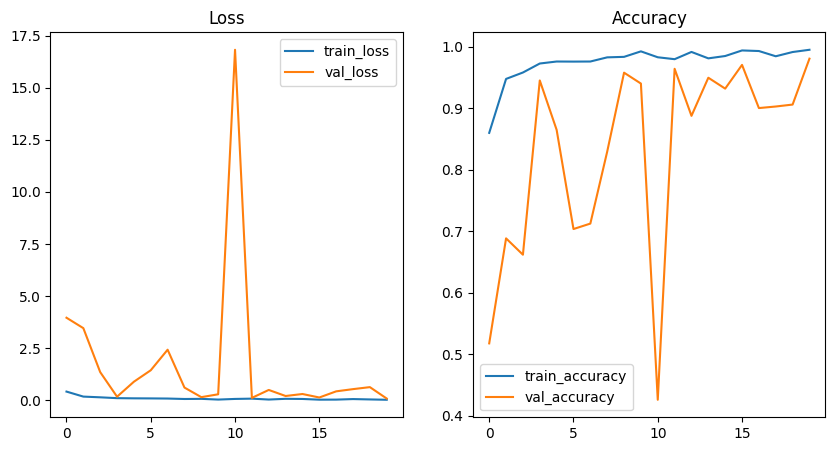

In [26]:
plot_results([base_densenet_results])

In [27]:
model_evaluation(base_densenet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.9982 - loss: 0.0090
Train Data, Loss: 0.0094, Accuracy: 0.9980
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9873 - loss: 0.0590
Val Data, Loss: 0.0767, Accuracy: 0.9804


### Base ResNet Model

In [28]:
rn_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
base_resnet = Sequential()
base_resnet.add(rn_base_model)
base_resnet.add(layers.GlobalAveragePooling2D())
base_resnet.add(layers.Dense(64, activation='relu'))
base_resnet.add(layers.Dropout(0.5))
base_resnet.add(layers.Dense(4, activation='softmax'))

In [30]:
base_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [31]:
base_resnet_results = base_resnet.fit(train_images, train_labels,
                                      epochs=20,
                                      batch_size=100,
                                      validation_data=(val_images, val_labels))

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 134s 843ms/step - accuracy: 0.7208 - loss: 0.7392 - val_accuracy: 0.2219 - val_loss: 1.9226
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9212 - loss: 0.2453 - val_accuracy: 0.2219 - val_loss: 1.6519
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.9606 - loss: 0.1295 - val_accuracy: 0.2219 - val_loss: 1.9811
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9571 - loss: 0.1451 - val_accuracy: 0.2219 - val_loss: 2.7739
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9661 - loss: 0.0972 - val_accuracy: 0.2212 - val_loss: 1.4708
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9814 - loss: 0.0737 - val_accuracy: 0.2592 - val_loss: 1.4217
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9819 - loss: 0.0642 - val_accuracy: 0.3774 - val_loss: 4.0416
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9838 - loss: 0.0495 - val_acc

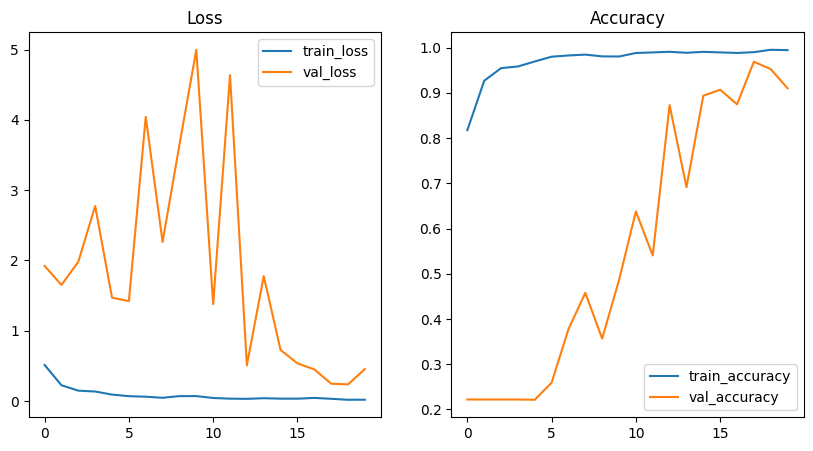

In [32]:
plot_results([base_resnet_results])

In [33]:
model_evaluation(base_resnet, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9325 - loss: 0.2790
Train Data, Loss: 0.2856, Accuracy: 0.9326
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9160 - loss: 0.4369
Val Data, Loss: 0.4556, Accuracy: 0.9102


# DenseNet Model

In [34]:
# Creating early stop callback variable
early_stop = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5, restore_best_weights=True)

In [35]:
dn_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [36]:
dn_model = Sequential()
dn_model.add(dn_base_model)
dn_model.add(layers.GlobalAveragePooling2D())
dn_model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(l2=0.2)))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(32, activation='relu'))
dn_model.add(layers.Dropout(0.5))
dn_model.add(layers.Dense(10, activation='relu'))
dn_model.add(layers.Dense(4, activation='softmax'))

dn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

dn_model_results = dn_model.fit(train_images, train_labels,
                                epochs=20,
                                batch_size=150,
                                validation_data=(val_images, val_labels),
                                callbacks=[early_stop])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.6676 - loss: 16.7170 - val_accuracy: 0.9507 - val_loss: 2.3786
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.9392 - loss: 1.4758 - val_accuracy: 0.9387 - val_loss: 0.3468
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9587 - loss: 0.2670 - val_accuracy: 0.9368 - val_loss: 0.3093
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9726 - loss: 0.1657 - val_accuracy: 0.9305 - val_loss: 0.3560
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.9780 - loss: 0.1368 - val_accuracy: 0.9753 - val_loss: 0.1466
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.9830 - loss: 0.1115 - val_accuracy: 0.9595 - val_loss: 0.2204
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.9778 - loss: 0.1433 - val_accuracy: 0.9254 - val_loss: 0.3400
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.9793 - loss: 0.1192 - val_accur

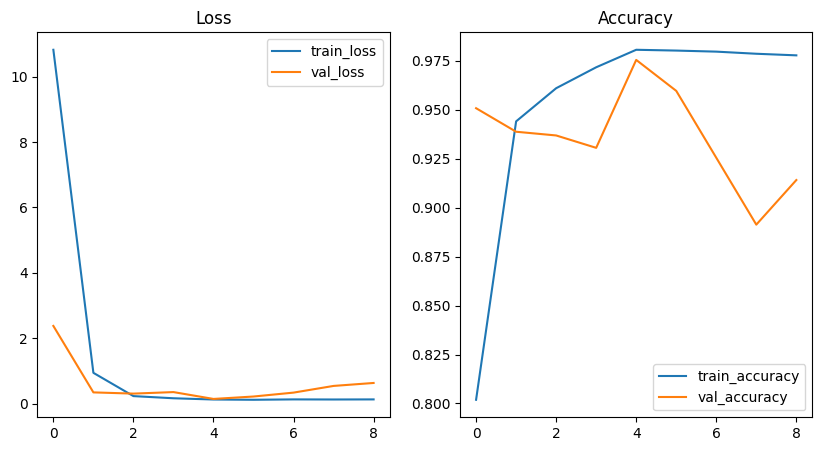

In [37]:
plot_results([dn_model_results])

In [38]:
model_evaluation(dn_model, data_dict)

231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.9777 - loss: 0.1320
Train Data, Loss: 0.1329, Accuracy: 0.9771
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.9660 - loss: 0.1864
Val Data, Loss: 0.2204, Accuracy: 0.9595


# Evaluation

In [39]:
final_model = dn_model

final_model.evaluate(test_images, test_labels)

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.9687 - loss: 0.2151


[0.19504310190677643, 0.9704030156135559]

In [40]:
# Getting test data pedictions
test_img_pred = final_model.predict(test_images)

# Converting test_img_pred and test_labels to single-label format
test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Classification report
print(classification_report(test_true_labels, test_img_pred_labels))

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       564
           1       0.92      0.96      0.94       352
           2       1.00      0.95      0.97       265
           3       0.99      0.98      0.99       407

    accuracy                           0.97      1588
   macro avg       0.97      0.97      0.97      1588
weighted avg       0.97      0.97      0.97      1588



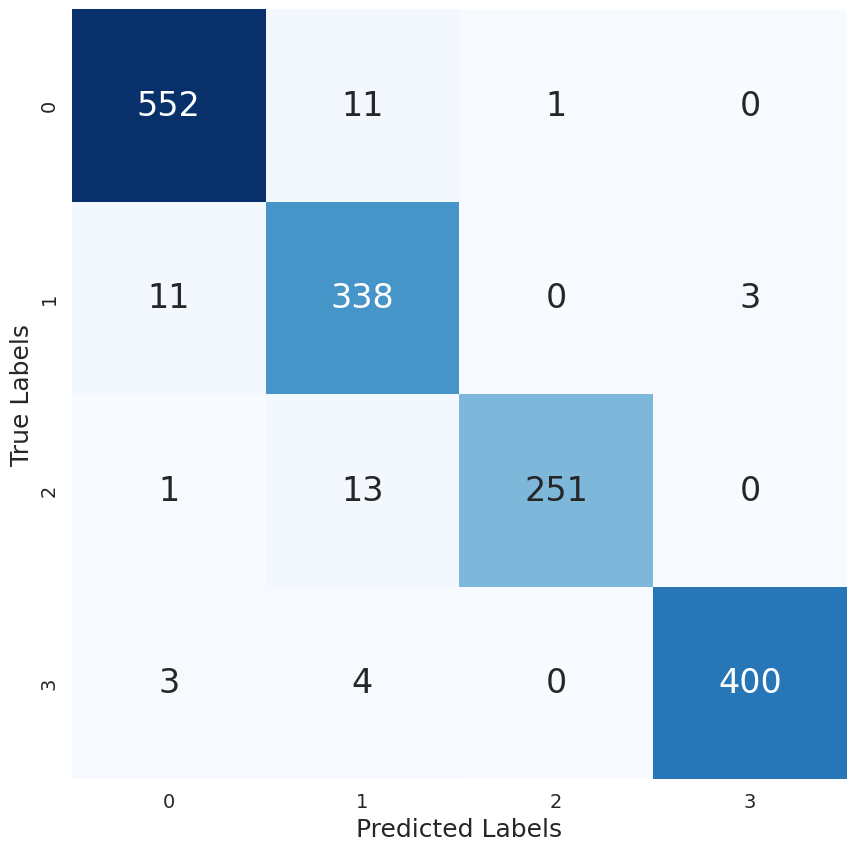

In [51]:
# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(test_true_labels, test_img_pred_labels)
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax, cbar=False)

ax.set_xlabel('Predicted Labels', fontsize=18)
ax.set_ylabel('True Labels', fontsize=18)

#ConfusionMatrixDisplay(confusion_matrix=cm,
#                       display_labels=['glioma', 'meningioma', 'no_tumor', 'pituitary']).plot(ax=ax, colorbar=False)

ax.tick_params(axis='both', labelsize=14)
#ax.set_title('Confusion Matrix', fontsize=25)
#ax.set_xlabel('Predicted Labels', fontsize=18)
#ax.set_ylabel('True Labels', fontsize=18);

# Limitations

# Next Steps